## EDS 220: Combining Shapefiles with Social Data in California Wildfire Analysis
###### Author: Henry Oliver
###### Github Repository: https://github.com/ht-oliver/eds220-hwk4

##### **Purpose**
The purpose of this walkthrough is to utilize socio-economic data in combination with fire perimeter shapefiles to answer the following environmental justice research question: Were any socio-economic demographics in Los Angeles County disproportionately affected by the Eaton and Palisades fires?

##### **Background**
Environmental justice examines how environmental hazards and disasters impact different communities, particularly whether vulnerable or marginalized populations bear a disproportionate burden. The January 2025 Palisades and Eaton fires destroyed thousands of structures across Los Angeles County. By combining fire perimeter data with Census demographic and socio-economic information, we can assess whether certain income levels, racial groups, or other demographic characteristics were overrepresented in affected areas—critical information for equitable recovery planning and future risk mitigation.

##### **Highlights**
- Merging shapefiles with Census socio-economic data
- Performing spatial joins to identify affected Census tracts
- Calculating demographic statistics for impacted vs. non-impacted areas

### **Part 1: Installing libraries**
Performing the data download, manipulation, and displays in this analysis requires the installation of several publicly-available software packages.

In [4]:
import os                       # File path operations and directory navigation
import pandas as pd             # Data manipulation and analysis with dataframes
import matplotlib.pyplot as plt # Creating visualizations and plots
import xarray as xr             # Multi-dimensional labeled arrays (NetCDF data)
import rioxarray as rioxr       # Geospatial raster operations with xarray
import netCDF4                  # Reading and writing NetCDF files
import geopandas as gpd         # Geospatial vector data (shapefiles, spatial joins)
import contextily as ctx        # Adding basemap tiles to geospatial plots

### **Part 2: Fire Perimeter data**

Let's repreat our steps from the last analysis to read in our fire perimeter data.

In [5]:
# Eaton
eaton = gpd.read_file(os.path.join('data',
                                   'Eaton_Perimeter_20250121',
                                   'Eaton_Perimeter_20250121.shp'))

# Palisades
palisades = gpd.read_file(os.path.join('data',
                                   'Palisades_Perimeter_20250121',
                                   'Palisades_Perimeter_20250121.shp'))


### **Part 3: Environmental Justice Data Import**

Next, we'll import our Environmental Justice/Socioeconomic data. Below is information on the data source.

California Environmental Justice Index (EJI)
- **File Name**: EJI_2024_California.gdb
- **Source**: https://calenviroscreen-oehha.hub.arcgis.com/documents/c1b480ac4b564f26a7d8c5582cab8b60/about
- **Publisher**: California Environmental Protection Agency
- **Date**: 2023


In this next step, we'll create file path for our EJI data, and read in the data with the `gpd.read_file()` method.

In [6]:
# Import CA EJI gdb
fp = os.path.join("data", "EJI_2024_California", "EJI_2024_California.gdb")
eji_california = gpd.read_file(fp)

### **Part 4: EJI Data Exploration**

Let's explore our EJI data, and determine what we'll need for our analysis

In [7]:
# Determine datatype
print(f"EJI datatype is: {type(eji_california)}")

# Determine CRS
print(f"EJI CRS is: {eji_california.crs}")

# View our columns
eji_california.columns.to_list



EJI datatype is: <class 'geopandas.geodataframe.GeoDataFrame'>
EJI CRS is: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]


<bound method IndexOpsMixin.tolist of Index(['OBJECTID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID',
       'GEOID_2020', 'COUNTY', 'StateDesc', 'STATEABBR',
       ...
       'TWOMORE', 'E_TWOMORE', 'OTHERRACE', 'E_OTHERRACE', 'Tribe_PCT_Tract',
       'Tribe_Names', 'Tribe_Flag', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object', length=174)>

#### **What did we learn?**

INCOMPLETE

In the next step of our analysis. We'll want to combine our fire perimeter data with our EJI data. The first step will be to match our CRSs using the `to_crs()` method

In [8]:
# Match CRS, overwrite with inplace = True
eji_california.to_crs(eaton.crs, inplace = True)

assert eji_california.crs == eaton.crs

### **Part 5: Joining EJI data to fire perimeter data**

If we want to view the distribution of socioeconomic variables within our fire perimeter, we'll need to join our two datasets together. We'll do this using the `gpd.join()` method. Within `gpd.join()` we'll use `intersects` in our `predicate` argument. The `predicate` argument species how the join will take place. `intersects` specifies that we'll select every census tract in our EJI data that touches the our fire perimeter. Then we'll make an exploratory plot to see if it worked

<Axes: >

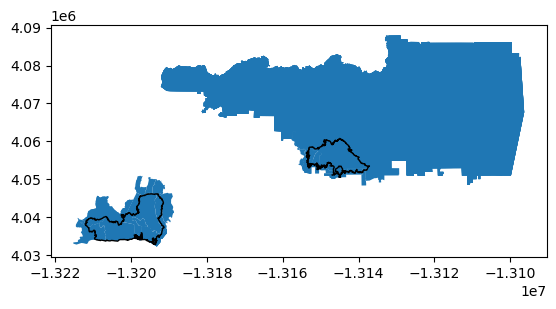

In [9]:
# Join EJI with palisades perimeter 
eji_palisades = gpd.sjoin(eji_california, palisades, predicate = 'intersects')

# Join EJI with eaton perimeter
eji_eaton = gpd.sjoin(eji_california, eaton, predicate = 'intersects')

# Create exploratory map to see how our join performed
fig, ax = plt.subplots() # Create axes
eji_palisades.plot(ax=ax) # Plot palisades
eji_eaton.plot(ax=ax) # Plot eaton

palisades.plot(ax = ax,
               color = 'none', 
               edgecolor = 'black') # Specify black outline

eaton.plot(ax = ax,
               color = 'none',
               edgecolor = 'black')

Notice that our fire outline is remarkably smaller than our census tract data. For our visualizations, we'll only want to see census tract area that's within our fire perimeters. The next step will walk us through how we can do that.


### **Part 6: Clip EJI Data to Fire Perimeters**

Let's clip our census tracts to our fire perimeters using the `gdp.clip()` method. Our two arguments will be the two datasets. Our first argument will be the dataset we want to clip, the second, the dataset that we would like to clip to.

<Axes: >

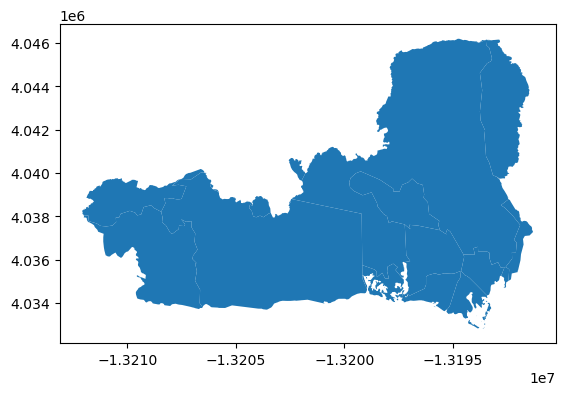

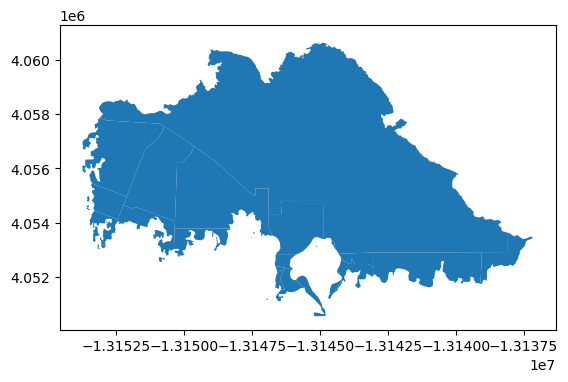

In [10]:
# Clip census tracts to fire boundaries

eji_palisades_clipped = gpd.clip(eji_california, palisades)
eji_eaton_clipped = gpd.clip(eji_california, eaton)

# Take a look at the shape of our new clipped EJI data
eji_palisades_clipped.plot()
eji_eaton_clipped.plot()

Now lets see how this lines up with our fire perimeters with another plot

<Axes: >

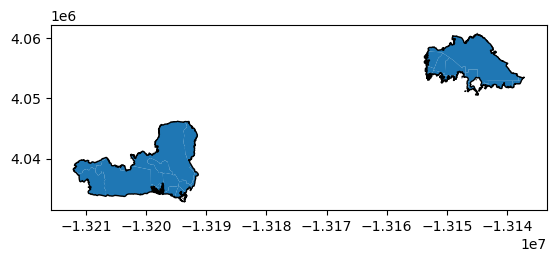

In [11]:
fig, ax = plt.subplots() # Define axes

eji_palisades_clipped.plot(ax=ax) # Plot palisades EJI data

palisades.plot(ax = ax, # Plot palisades fire perimeter
               color = 'none',
               edgecolor = 'black')

eji_eaton_clipped.plot(ax=ax) # Plot eaton EJI data

eaton.plot(ax = ax, # Plot eaton fire perimeter
               color = 'none',
               edgecolor = 'black')

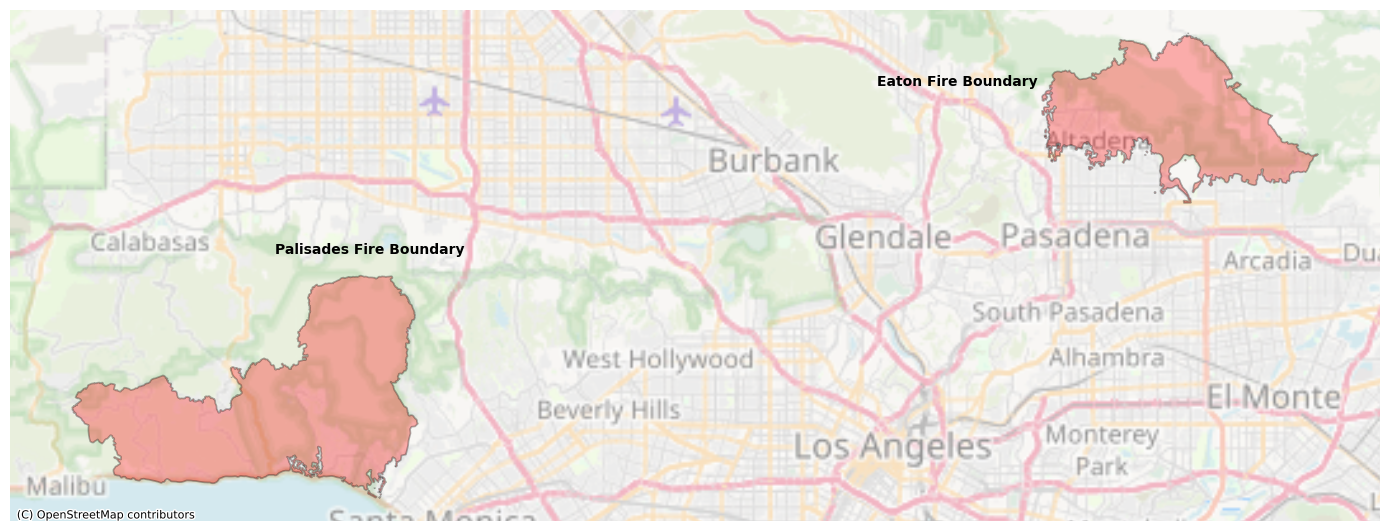

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR
palisades.plot(ax =ax,
               edgecolor = 'black',
               color = 'red',
               linewidth = 1.25,
               alpha = 0.3)

eaton.plot(ax =ax,
               edgecolor = 'black',
               color = 'red',
               linewidth = 1.25,
               alpha = 0.3)

# ADD LEGEND OR ANNOTATION TO IDENTIFY EACH FIRE

plt.figtext(x = .63,
            y = .65,
            s = "Eaton Fire Boundary",
            weight = 'bold')

plt.figtext(x = .2,
            y = .51,
            s = "Palisades Fire Boundary",
            weight = 'bold')




# ADD TITLE

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
                alpha = 0.5)

ax.axis('off')

plt.tight_layout()
plt.show()




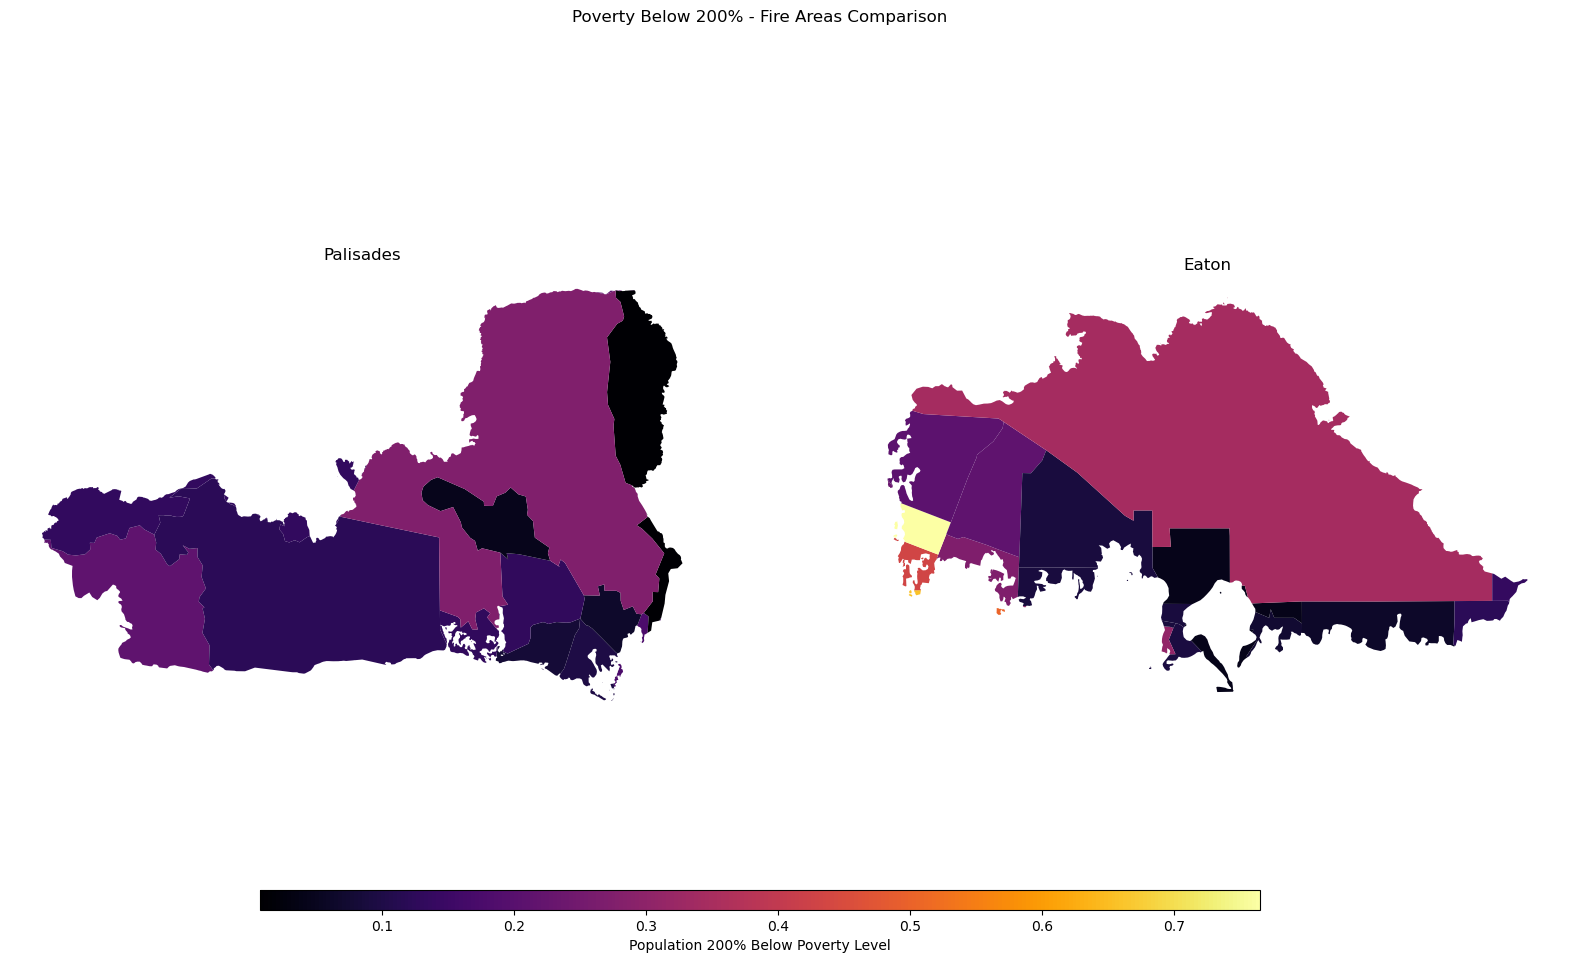

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# UPDATE WITH YOU EJI VARIABLE FROM STEP 1
eji_variable = 'EPL_POV200'

# Find common min/max for legend range
vmin = min(eji_palisades_clipped[eji_variable].min(), eji_eaton_clipped[eji_variable].min())
vmax = max(eji_palisades_clipped[eji_variable].max(), eji_eaton_clipped[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_palisades_clipped.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap = 'inferno'
)
ax1.set_title('Palisades')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eaton_clipped.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap = 'inferno'
)
ax2.set_title('Eaton')
ax2.axis('off')

# Add overall title
fig.suptitle('Poverty Below 200% - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap = 'inferno')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Population 200% Below Poverty Level')

plt.show()